In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

## 2 The Factors
### 1 Analyze the factors

In [3]:
df = pd.read_excel("factor_pricing_data_monthly.xlsx", sheet_name="factors (excess returns)")
df.set_index("Date", inplace=True)
df

,MKT,SMB,HML,RMW,CMA,UMD
Date,,,,,,
1980-01-31,0.0550,0.0188,0.0185,-0.0184,0.0189,0.0745
1980-02-29,-0.0123,-0.0162,0.0059,-0.0095,0.0292,0.0789
1980-03-31,-0.1289,-0.0697,-0.0096,0.0182,-0.0105,-0.0958
1980-04-30,0.0396,0.0105,0.0103,-0.0218,0.0034,-0.0048
1980-05-31,0.0526,0.0200,0.0038,0.0043,-0.0063,-0.0118
...,...,...,...,...,...,...
2025-04-30,-0.0084,-0.0186,-0.0340,-0.0285,-0.0267,0.0497
2025-05-31,0.0606,-0.0072,-0.0288,0.0126,0.0251,0.0221
2025-06-30,0.0486,-0.0002,-0.0160,-0.0319,0.0145,-0.0264


In [4]:
mean = df.mean(axis=0) * 12
vol = df.std(axis=0) * np.sqrt(12)
sharpe = mean / vol

result = pd.DataFrame([mean, vol, sharpe], index = ["mean", "vol", "sharpe"]).T
result

,mean,vol,sharpe
MKT,0.087552,0.156142,0.560718
SMB,0.006120,0.101274,0.060435
HML,0.026039,0.108835,0.239249
RMW,0.044047,0.082931,0.531132
CMA,0.028288,0.072480,0.390284
UMD,0.060313,0.153352,0.393299


## 2. Factor Analysis


**From the result above, it is clear that each factor has a positive risk premium**

**To analyze how the factors have performed, we conduct the following analysis:**

In [5]:
df_2015 = df.loc["2015":]
df_2015

,MKT,SMB,HML,RMW,CMA,UMD
Date,,,,,,
2015-01-31,-0.0309,-0.0093,-0.0345,0.0158,-0.0164,0.0374
2015-02-28,0.0614,0.0036,-0.0179,-0.0110,-0.0175,-0.0310
2015-03-31,-0.0109,0.0308,-0.0038,0.0007,-0.0062,0.0270
2015-04-30,0.0060,-0.0301,0.0180,0.0005,-0.0062,-0.0727
2015-05-31,0.0138,0.0082,-0.0111,-0.0176,-0.0083,0.0568
...,...,...,...,...,...,...
2025-04-30,-0.0084,-0.0186,-0.0340,-0.0285,-0.0267,0.0497
2025-05-31,0.0606,-0.0072,-0.0288,0.0126,0.0251,0.0221
2025-06-30,0.0486,-0.0002,-0.0160,-0.0319,0.0145,-0.0264


In [6]:
mean = df_2015.mean(axis=0) * 12
vol = df_2015.std(axis=0) * np.sqrt(12)
sharpe = mean / vol

result = pd.DataFrame([mean, vol, sharpe], index = ["mean", "vol", "sharpe"]).T
result

,mean,vol,sharpe
MKT,0.117872,0.157356,0.749078
SMB,-0.023775,0.103166,-0.230455
HML,-0.016303,0.129885,-0.125520
RMW,0.040012,0.072632,0.550896
CMA,-0.009141,0.082072,-0.111373
UMD,0.020119,0.137387,0.146438


**From the result above, it is clear that some of the factors have performed worse since 2015, such as SMB , CMA and UMD, which has a lower excess return mean after 2015, dragging down the total average**


## 3.Correlation Matrix Across Factors

<Axes: >

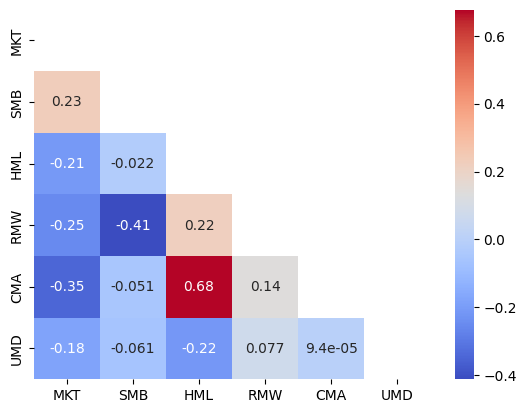

In [7]:
import seaborn as sn

correlation = df.corr()

mask = np.triu(np.ones_like(correlation, dtype=bool))

sn.heatmap(correlation, mask = mask, annot=True, cmap="coolwarm")

**The construction method did succceed in keeping correlations generally small. HML does seem redundant since it is heavily correlated with the investments factor**

## 4. Tangency Portfolio

In [8]:
def optimized_weights(returns,dropna=True,scale_cov=1):
    if dropna:
        returns = returns.dropna()

    covmat_full = returns.cov()
    covmat_diag = np.diag(np.diag(covmat_full))
    covmat = scale_cov * covmat_full + (1-scale_cov) * covmat_diag

    weights = np.linalg.solve(covmat,returns.mean())
    weights = weights / weights.sum()

    if returns.mean() @ weights < 0:
        weights = -weights

    return pd.DataFrame(weights, index=returns.columns)


In [9]:
weights_1 = np.linalg.inv(df.cov()) @ df.mean(axis=0)
weights_1 = weights_1 / weights_1.sum()
weights_1 = pd.Series(weights_1, index = df.columns)

result_comparison = pd.DataFrame([sharpe, mean, weights_1], index = ["sharpe", "mean", "weights"])
result_comparison

,MKT,SMB,HML,RMW,CMA,UMD
sharpe,0.749078,-0.230455,-0.125520,0.550896,-0.111373,0.146438
mean,0.117872,-0.023775,-0.016303,0.040012,-0.009141,0.020119
weights,0.218650,0.066849,-0.021212,0.301829,0.321431,0.112453


In [10]:
optimized_result = optimized_weights(df)
result_comparison_2 = pd.DataFrame([sharpe, mean], index = ["sharpe", "mean"]).T
result_comparison_2 = pd.concat([result_comparison_2, optimized_result], axis=1)
result_comparison_2.rename(columns={0:"Weights"}, inplace=True)
result_comparison_2

,sharpe,mean,Weights
MKT,0.749078,0.117872,0.218650
SMB,-0.230455,-0.023775,0.066849
HML,-0.125520,-0.016303,-0.021212
RMW,0.550896,0.040012,0.301829
CMA,-0.111373,-0.009141,0.321431
UMD,0.146438,0.020119,0.112453


**Profitability seems the most important in the tangency portfolio, while the book market ratio factor and size factor seem the least important in constructing the optimal portfolio**

In [11]:
df_adjusted = df[["MKT", "SMB", "HML","UMD"]]

mean_new = df_adjusted.mean(axis=0)
sharpe_new = mean_new / df_adjusted.std(axis=0)

weights_new = optimized_weights(df_adjusted)

result_comparison = pd.DataFrame([sharpe_new, mean_new], index = ["sharpe", "mean"]).T

print(result_comparison.join(weights_new))


       sharpe      mean         0
MKT  0.161865  0.007296  0.376514
SMB  0.017446  0.000510 -0.051198
HML  0.069065  0.002170  0.365321
UMD  0.113536  0.005026  0.309363


**MKT and HML has very high tangency weights now while SMB has the lowest tangency weight**

## 3 Testing Modern LPMs
### 1

In [12]:
port_df = pd.read_excel("factor_pricing_data_monthly.xlsx", sheet_name="portfolios (excess returns)")
port_df.set_index("Date", inplace=True)
port_df.head()

,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
Date,,,,,,,,,,,,,,,,,,,,,
1980-01-31,-0.0073,0.0285,0.0084,0.1009,-0.0143,0.0995,0.0348,0.0323,0.0048,0.0059,...,0.0158,0.0851,0.0466,-0.0125,0.0430,-0.0284,0.0254,0.0770,0.0306,0.0666
1980-02-29,0.0125,-0.0609,-0.0967,-0.0323,-0.0575,-0.0316,-0.0492,-0.0803,-0.0556,-0.0169,...,-0.0083,-0.0543,-0.0345,-0.0641,-0.0653,-0.0824,-0.0960,-0.0352,-0.0283,-0.0273
1980-03-31,-0.2220,-0.1119,-0.0158,-0.1535,-0.0188,-0.1272,-0.0827,-0.1238,-0.0567,-0.0670,...,-0.0819,-0.1512,-0.1602,-0.0905,-0.1450,-0.0559,-0.0877,-0.2449,-0.1261,-0.1737
1980-04-30,0.0449,0.0767,0.0232,0.0289,0.0830,-0.0529,0.0785,0.0154,0.0305,0.0115,...,0.0422,-0.0102,0.0268,0.0355,0.0539,0.0736,0.0528,0.0964,0.0458,0.0784
1980-05-31,0.0635,0.0797,0.0458,0.0866,0.0822,0.0510,0.0325,0.0888,0.0560,0.0098,...,0.0564,0.1065,0.1142,0.0877,0.1104,0.0570,0.0560,0.0889,0.0846,0.0663


In [25]:
alpha = []
r_squared = []

for col in port_df.columns:

    model = LinearRegression()

    X = df[['MKT','HML', 'RMW', 'UMD']]

    predict = port_df[[col]]

    model.fit(X=X, y=predict)

    y_pred = model.predict(X)

    alpha.append(float(model.intercept_[0]))
    
    r_squared.append(r2_score(predict, y_pred))


alpha = [i * 12 for i in alpha]
AQR_result = pd.DataFrame([pd.Series(alpha), pd.Series(r_squared)], index=["alpha", "r_squared"])
result

,0,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
alpha,0.007169,-0.006417,-0.001696,0.004104,0.020507,-0.062884,0.024146,-0.048843,-0.024517,-0.044987,...,-0.011558,-0.033621,-0.025142,0.017185,-0.016304,-0.016047,-0.011021,-0.074413,0.028115,-0.047154
r_squared,0.361897,0.478102,0.306403,0.433565,0.294362,0.550938,0.599511,0.702187,0.581884,0.629068,...,0.578747,0.720979,0.797406,0.688867,0.646986,0.781911,0.665301,0.690753,0.820892,0.584369


### 2. Mean absolute error 

In [14]:
MAE = 1/len(alpha) * np.sum(np.abs(alpha))
MAE

np.float64(0.02461084904163791)

- If the pricing model worked, the alpha estimates whould be small, because the return on a specific portfolio should only be explained by a specific factor. My MAE stat seems to not support the pricing model.

### 3. CAPM, FF 3-Factor, and FF-5 Factor

## CAPM

In [21]:
alpha = []
r_squared = []

for col in port_df.columns:

    model = LinearRegression()

    X = df[['MKT']]

    predict = port_df[[col]]

    model.fit(X=X, y=predict)

    y_pred = model.predict(X)

    alpha.append(float(model.intercept_[0]))
    
    r_squared.append(r2_score(predict, y_pred))


alpha = [i * 12 for i in alpha]
CAPM_result = pd.DataFrame([pd.Series(alpha), pd.Series(r_squared)], index=["alpha", "r_squared"])
MAE = 1/len(alpha) * np.sum(np.abs(alpha))
MAE

np.float64(0.020970330677320563)

## FF 3-Factor

In [22]:
alpha = []
r_squared = []

for col in port_df.columns:

    model = LinearRegression()

    X = df[['MKT', 'SMB', 'HML']]

    predict = port_df[[col]]

    model.fit(X=X, y=predict)

    y_pred = model.predict(X)

    alpha.append(float(model.intercept_[0]))
    
    r_squared.append(r2_score(predict, y_pred))


alpha = [i * 12 for i in alpha]
FF_3_result = pd.DataFrame([pd.Series(alpha), pd.Series(r_squared)], index=["alpha", "r_squared"])
MAE = 1/len(alpha) * np.sum(np.abs(alpha))
MAE

np.float64(0.02435805912262935)

## FF - 5F

In [23]:
alpha = []
r_squared = []

for col in port_df.columns:

    model = LinearRegression()

    X = df[['MKT', 'SMB', 'HML', 'RMW', 'CMA']]

    predict = port_df[[col]]

    model.fit(X=X, y=predict)

    y_pred = model.predict(X)

    alpha.append(float(model.intercept_[0]))
    
    r_squared.append(r2_score(predict, y_pred))


alpha = [i * 12 for i in alpha]
FF_5_result = pd.DataFrame([pd.Series(alpha), pd.Series(r_squared)], index=["alpha", "r_squared"])
MAE = 1/len(alpha) * np.sum(np.abs(alpha))
MAE

np.float64(0.0313720898138194)

- The CAPM seems to perform the best due to low alpha

In [31]:
R_squared_df = pd.DataFrame({
    "CAPM": pd.Series(CAPM_result.loc["r_squared"].values, index=port_df.columns),
    "FF-3F": pd.Series(FF_3_result.loc["r_squared"].values, index=port_df.columns),
    "FF-5F": pd.Series(FF_5_result.loc["r_squared"].values, index=port_df.columns),
    "AQR": pd.Series(AQR_result.loc["r_squared"].values, index=port_df.columns)
})
R_squared_df

,CAPM,FF-3F,FF-5F,AQR
Agric,0.333250,0.357284,0.361897,0.342074
Food,0.354061,0.404117,0.478102,0.455064
Soda,0.244924,0.273442,0.306403,0.302544
Beer,0.324409,0.351807,0.433565,0.414773
Smoke,0.182141,0.231158,0.294362,0.265363
Toys,0.496254,0.530488,0.550938,0.510213
Fun,0.586071,0.595204,0.599511,0.607213
Books,0.655139,0.691110,0.702187,0.688933
Hshld,0.486218,0.504338,0.581884,0.554712
Clths,0.560742,0.573901,0.629068,0.618968


In [32]:
avg_r_squared = R_squared_df.mean()
avg_rs = pd.DataFrame(avg_r_squared, columns=["Average R_squared"])
avg_rs

,Average R_squared
CAPM,0.522622
FF-3F,0.567874
FF-5F,0.591768
AQR,0.571935


In [36]:
import sys
sys.path.append('..')
from portfolio_management_helper import calc_cross_section_regression

CAPM_cross_section = calc_cross_section_regression(returns = port_df, factors = df[['MKT']])
CAPM_cross_section

Assuming monthly returns with annualization term of 12
Assuming excess returns were provided
Lambda represents the premium calculated by the cross-section regression and the historical premium is the average of the factor excess returns


,Eta,Annualized Eta,R-Squared,MKT Lambda,Treynor Ratio,Annualized Treynor Ratio,MKT Annualized Lambda,MKT Historical Premium,MKT Annualized Historical Premium,TS MAE,TS Annualized MAE,CS MAE,CS Annualized MAE
MKT Cross-Section Regression,0.0069,0.0832,0.0093,0.0007,11.5196,138.2352,0.0079,0.0073,0.0876,0.0017,0.0210,0.0013,0.0152


In [37]:
FF_5_cross_section = calc_cross_section_regression(returns = port_df, factors = df[['MKT', 'SMB', 'HML', 'RMW', 'CMA']])
FF_5_cross_section

Assuming monthly returns with annualization term of 12
Assuming excess returns were provided
Lambda represents the premium calculated by the cross-section regression and the historical premium is the average of the factor excess returns


,Eta,Annualized Eta,R-Squared,MKT Lambda,SMB Lambda,HML Lambda,RMW Lambda,CMA Lambda,MKT Annualized Lambda,SMB Annualized Lambda,...,CMA Historical Premium,MKT Annualized Historical Premium,SMB Annualized Historical Premium,HML Annualized Historical Premium,RMW Annualized Historical Premium,CMA Annualized Historical Premium,TS MAE,TS Annualized MAE,CS MAE,CS Annualized MAE
MKT + SMB + HML + RMW + CMA Cross-Section Regression,0.0050,0.0599,0.3765,0.0034,-0.0035,-0.0022,0.0016,-0.0018,0.0403,-0.0414,...,0.0024,0.0876,0.0061,0.0260,0.0440,0.0283,0.0026,0.0314,0.0010,0.0120


In [39]:
FF_3_cross_section = calc_cross_section_regression(returns = port_df, factors = df[['MKT','SMB','HML']])
FF_3_cross_section

Assuming monthly returns with annualization term of 12
Assuming excess returns were provided
Lambda represents the premium calculated by the cross-section regression and the historical premium is the average of the factor excess returns


,Eta,Annualized Eta,R-Squared,MKT Lambda,SMB Lambda,HML Lambda,MKT Annualized Lambda,SMB Annualized Lambda,HML Annualized Lambda,MKT Historical Premium,SMB Historical Premium,HML Historical Premium,MKT Annualized Historical Premium,SMB Annualized Historical Premium,HML Annualized Historical Premium,TS MAE,TS Annualized MAE,CS MAE,CS Annualized MAE
MKT + SMB + HML Cross-Section Regression,0.0052,0.0627,0.3504,0.0032,-0.0033,-0.0018,0.0388,-0.0396,-0.0210,0.0073,0.0005,0.0022,0.0876,0.0061,0.0260,0.0020,0.0244,0.0010,0.0120
